In [1]:
from google.colab import files
import zipfile
import os

# Manually upload ZIP file
uploaded = files.upload()

# Get the uploaded file name
zip_filename = list(uploaded.keys())[0]
zip_path = os.path.join("/content", zip_filename)

# Extract the ZIP file
extract_path = "/content/Segmented"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Extracted dataset to: {extract_path}")


Saving archive (3).zip to archive (3).zip
✅ Extracted dataset to: /content/Segmented


In [2]:
import pandas as pd

# Define extracted dataset path
base_dir = "/content/Segmented"

# Check if the directory exists
if not os.path.exists(base_dir):
    print(f"❌ Directory not found: {base_dir}")
else:
    print(f"✅ Found dataset at: {base_dir}")

# Define leukemia categories (update if needed)
categories = ["Benign", "Early", "Pre", "Pro"]

# List to store data
data = []

# Iterate through category folders
for category in categories:
    category_path = os.path.join(base_dir, category)

    if os.path.exists(category_path):  # Check if folder exists
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)

            # Ensure it's an image file
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append([file_name, category, file_path])  # Store filename, label, and full path

# Create a DataFrame
df = pd.DataFrame(data, columns=["File Name", "Label", "File Path"])

# Save as CSV
csv_path = "/content/leukemia_dataset.csv"
df.to_csv(csv_path, index=False)

print(f"✅ Dataset saved as {csv_path} with {len(df)} entries.")


✅ Found dataset at: /content/Segmented
✅ Dataset saved as /content/leukemia_dataset.csv with 0 entries.


In [3]:
df = pd.read_csv("/content/leukemia_dataset.csv")
print(df.head())  # Should show "File Name", "Label", "File Path"


Empty DataFrame
Columns: [File Name, Label, File Path]
Index: []


In [4]:
import os

extract_path = "/content/Segmented"
if os.path.exists(extract_path):
    print(f"✅ Found extracted dataset at: {extract_path}")
    print("📂 Extracted contents:", os.listdir(extract_path))
else:
    print("❌ Dataset extraction failed!")


✅ Found extracted dataset at: /content/Segmented
📂 Extracted contents: ['Original', 'Segmented']


In [5]:
import os

extract_path = "/content/Segmented"

# Check contents of "Segmented" folder
for subfolder in os.listdir(extract_path):
    subfolder_path = os.path.join(extract_path, subfolder)
    if os.path.isdir(subfolder_path):
        print(f"📂 {subfolder}: {os.listdir(subfolder_path)[:5]}")  # Show first 5 files/folders


📂 Original: ['Pro', 'Pre', 'Early', 'Benign']
📂 Segmented: ['Pro', 'Pre', 'Early', 'Benign']


In [6]:
import shutil

segmented_path = "/content/Segmented/Segmented"

if os.path.exists(segmented_path):
    for folder in os.listdir(segmented_path):
        source = os.path.join(segmented_path, folder)
        destination = os.path.join("/content/Segmented", folder)
        if os.path.isdir(source):
            shutil.move(source, destination)
            print(f"✅ Moved {folder} to /content/Segmented/")


✅ Moved Pro to /content/Segmented/
✅ Moved Pre to /content/Segmented/
✅ Moved Early to /content/Segmented/
✅ Moved Benign to /content/Segmented/


In [7]:
import os
import pandas as pd

# Define the corrected dataset path
base_dir = "/content/Segmented"

# Check if the directory exists
if not os.path.exists(base_dir):
    print(f"❌ Directory not found: {base_dir}")
else:
    print(f"✅ Found dataset at: {base_dir}")

# Define leukemia categories
categories = ["Benign", "Early", "Pre", "Pro"]

# List to store data
data = []

# Iterate through category folders
for category in categories:
    category_path = os.path.join(base_dir, category)

    if os.path.exists(category_path):  # Check if folder exists
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)

            # Ensure it's an image file
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append([file_name, category, file_path])  # Store filename, label, and full path

# Create a DataFrame
df = pd.DataFrame(data, columns=["File Name", "Label", "File Path"])

# Save as CSV
csv_path = "/content/leukemia_dataset.csv"
df.to_csv(csv_path, index=False)

print(f"✅ Dataset saved as {csv_path} with {len(df)} entries.")


✅ Found dataset at: /content/Segmented
✅ Dataset saved as /content/leukemia_dataset.csv with 3256 entries.


## Step 1: Load Dataset & Preprocess Images





In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Load dataset
df = pd.read_csv("/content/leukemia_dataset.csv")

# Ensure 'File Path' exists
if "File Path" not in df.columns:
    raise ValueError("Column 'File Path' not found in the dataset!")

image_paths = df["File Path"].values
labels = df["Label"].values

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Save label encoder
import pickle
with open("/content/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Define image preprocessing function
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Normalize
    return img


## Step 2: Load ResNet Models

In [9]:
# Load ResNet-50 & ResNet-101 models without top layers
base_model_50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling layer to extract features
model_50 = Model(inputs=base_model_50.input, outputs=GlobalAveragePooling2D()(base_model_50.output))
model_101 = Model(inputs=base_model_101.input, outputs=GlobalAveragePooling2D()(base_model_101.output))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Step 3: Extract Features Using ResNet-50 & ResNet-101

In [10]:
# Extract features using ResNet-50 & ResNet-101
features_50 = []
features_101 = []

for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        continue

    img = preprocess_image(img_path)

    # Extract features
    features_50.append(model_50.predict(img)[0])
    features_101.append(model_101.predict(img)[0])

# Convert lists to NumPy arrays
features_50 = np.array(features_50)
features_101 = np.array(features_101)

# Save extracted features
np.save("/content/resnet50_features.npy", features_50)
np.save("/content/resnet101_features.npy", features_101)

print(f"✅ Feature extraction complete!")
print(f"📂 ResNet-50 Features: {features_50.shape}")
print(f"📂 ResNet-101 Features: {features_101.shape}")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━

## Step 4: Verify Extracted Features

In [11]:
# Load saved features
features_50 = np.load("/content/resnet50_features.npy")
features_101 = np.load("/content/resnet101_features.npy")

print(f"ResNet-50 Features Shape: {features_50.shape}")
print(f"ResNet-101 Features Shape: {features_101.shape}")


ResNet-50 Features Shape: (3256, 2048)
ResNet-101 Features Shape: (3256, 2048)


## Step 5 : Load Extracted Features & Labels






In [12]:
import numpy as np
import pandas as pd
import pickle

# Load extracted features
features_50 = np.load("/content/resnet50_features.npy")
features_101 = np.load("/content/resnet101_features.npy")

# Load labels
df = pd.read_csv("/content/leukemia_dataset.csv")

# Load label encoder
with open("/content/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Encode labels
y = label_encoder.transform(df["Label"].values)

# Print feature shapes
print(f"ResNet-50 Features Shape: {features_50.shape}")
print(f"ResNet-101 Features Shape: {features_101.shape}")
print(f"Labels Shape: {y.shape}")


ResNet-50 Features Shape: (3256, 2048)
ResNet-101 Features Shape: (3256, 2048)
Labels Shape: (3256,)


## Step 6: Split Data for Training & Testing

In [13]:
from sklearn.model_selection import train_test_split

# Use ResNet-50 features for training first
X_train, X_test, y_train, y_test = train_test_split(features_50, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")


Training Samples: 2604
Testing Samples: 652


## Step 7: Train an SVM Classifier



✅ **SVM Classifier Performance:**
Accuracy: 0.8773
Precision: 0.8771
Recall: 0.8773
F1-score: 0.8759
AUC-ROC: 0.9793

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.78       124
           1       0.83      0.89      0.86       196
           2       0.91      0.90      0.91       182
           3       0.92      0.96      0.94       150

    accuracy                           0.88       652
   macro avg       0.88      0.87      0.87       652
weighted avg       0.88      0.88      0.88       652



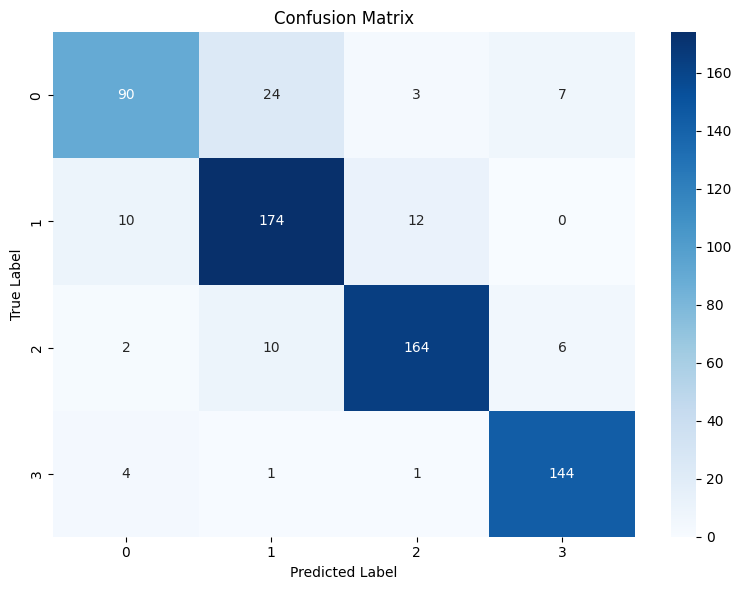

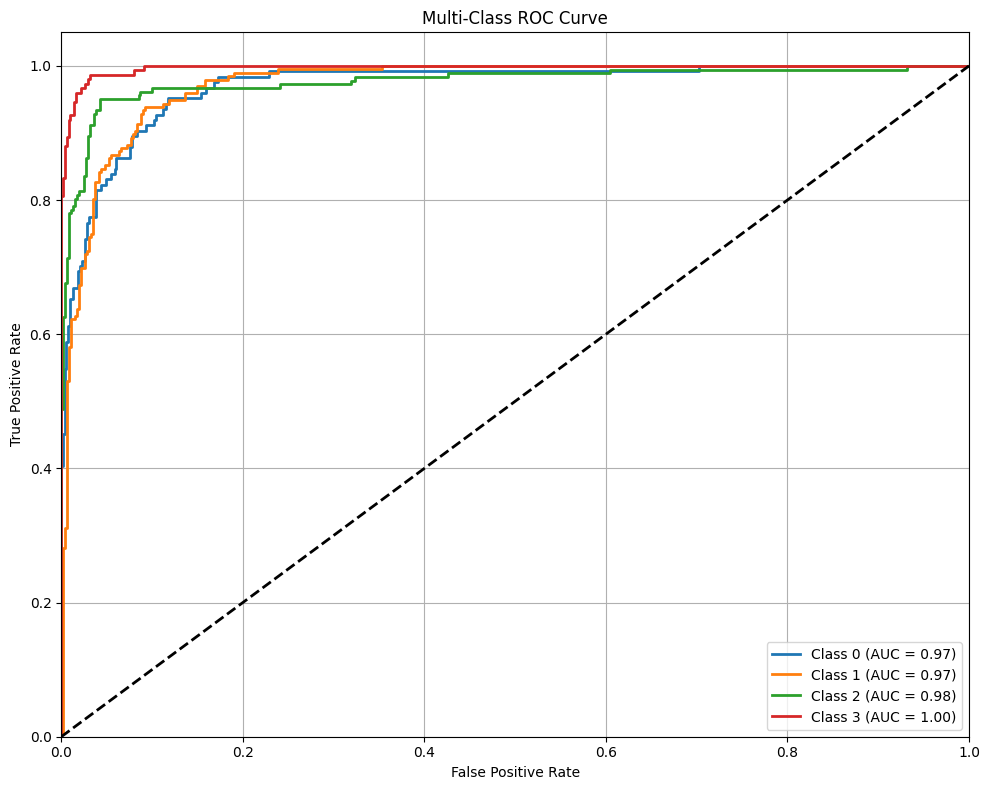

✅ SVM model saved as 'svm_resnet50.pkl'


In [15]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Train SVM model
svm_classifier = SVC(kernel="linear", probability=True)
svm_classifier.fit(X_train, y_train)

# Predict & Evaluate
y_pred = svm_classifier.predict(X_test)
y_pred_probs = svm_classifier.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_roc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, multi_class="ovr")

# Print results
print(f"✅ **SVM Classifier Performance:**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ROC Curve (for multi-class)
y_test_bin = label_binarize(y_test, classes=svm_classifier.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {svm_classifier.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Save trained model
with open("/content/svm_resnet50.pkl", "wb") as f:
    pickle.dump(svm_classifier, f)
print("✅ SVM model saved as 'svm_resnet50.pkl'")


## Step 8: Train a Softmax Classifier

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ **Softmax Classifier Performance:**
Accuracy: 0.8758
Precision: 0.8781
Recall: 0.8758
F1-score: 0.8736
AUC-ROC: 0.9758

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78       124
           1       0.82      0.90      0.86       196
           2       0.91      0.90      0.90       182
           3       0.90      0.97      0.93       150

    accuracy                           0.88       652
   macro avg       0.88      0.86      0.87       652
weighted avg       0.88      0.88      0.87       652



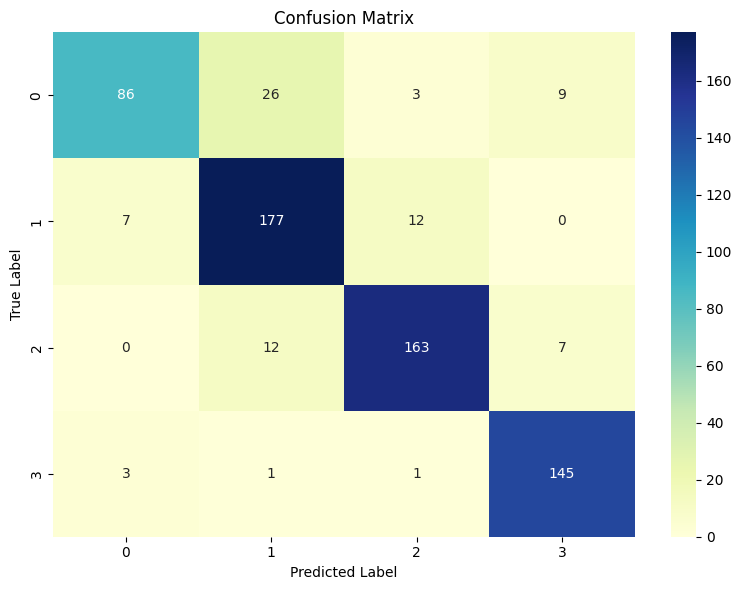

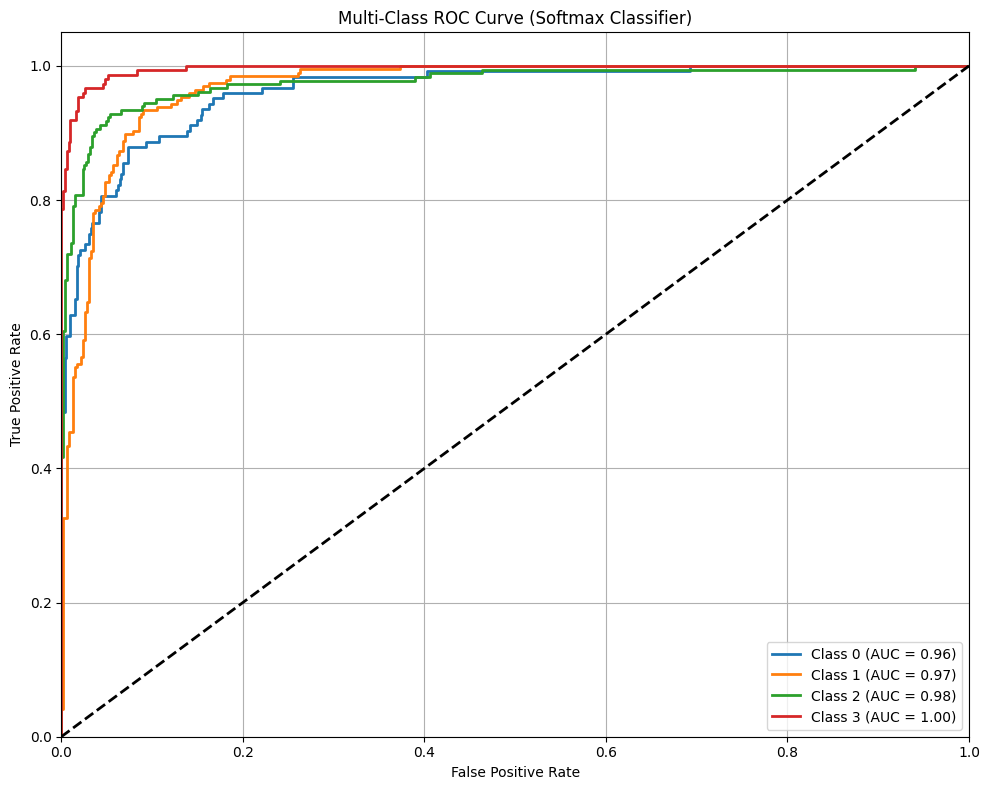

✅ Softmax model saved as 'softmax_resnet50.pkl'


In [17]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Train Softmax classifier
softmax_classifier = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs')
softmax_classifier.fit(X_train, y_train)

# Predict & Evaluate
y_pred = softmax_classifier.predict(X_test)
y_pred_probs = softmax_classifier.predict_proba(X_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_roc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, multi_class="ovr")

# Print results
print(f"✅ **Softmax Classifier Performance:**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=softmax_classifier.classes_,
            yticklabels=softmax_classifier.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ROC Curve (multi-class)
y_test_bin = label_binarize(y_test, classes=softmax_classifier.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {softmax_classifier.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (Softmax Classifier)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Save trained model
with open("/content/softmax_resnet50.pkl", "wb") as f:
    pickle.dump(softmax_classifier, f)

print("✅ Softmax model saved as 'softmax_resnet50.pkl'")


## Step 9: Train a Fully Connected Neural Network (FCNN)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define FCNN Model
fcnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])

# Compile model
fcnn_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train model
history = fcnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Save trained FCNN model
fcnn_model.save("/content/fcnn_resnet50.h5")
print("✅ FCNN model saved as 'fcnn_resnet50.h5'")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5334 - loss: 1.1386 - val_accuracy: 0.6994 - val_loss: 0.7727
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7324 - loss: 0.7065 - val_accuracy: 0.7393 - val_loss: 0.6992
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7283 - loss: 0.6997 - val_accuracy: 0.7239 - val_loss: 0.6509
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7347 - loss: 0.6628 - val_accuracy: 0.7193 - val_loss: 0.7121
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7440 - loss: 0.6617 - val_accuracy: 0.7239 - val_loss: 0.6245
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7672 - loss: 0.6061 - val_accuracy: 0.7362 - val_loss: 0.6405
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7716 - loss: 0.5880 - val_accuracy: 0.7377 - val_loss: 0.6122
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7583 - loss: 0.6079 - val_accuracy: 0.7408 - v

✅ FCNN model saved as 'fcnn_resnet50.h5'


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4867 - loss: 1.2094 - val_accuracy: 0.6887 - val_loss: 0.8246
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7083 - loss: 0.7611 - val_accuracy: 0.7209 - val_loss: 0.6696
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7401 - loss: 0.6540 - val_accuracy: 0.7316 - val_loss: 0.6456
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7365 - loss: 0.6515 - val_accuracy: 0.7377 - val_loss: 0.6116
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7411 - loss: 0.6643 - val_accuracy: 0.7331 - val_loss: 0.6481
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7373 - loss: 0.6361 - val_accuracy: 0.7362 - val_loss: 0.6096
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7610 - loss: 0.6082 - val_accuracy: 0.7362 - val_loss: 0.5941
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7579 - loss: 0.6251 - val_accuracy: 0.7193 - v

✅ FCNN model saved as 'fcnn_resnet50.h5'
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

✅ **FCNN Model Evaluation:**
Accuracy: 0.7454
Precision: 0.8125
Recall: 0.7454
F1-score: 0.6941
AUC-ROC: 0.9456

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.10      0.18       124
           1       0.63      0.94      0.75       196
           2       0.92      0.77      0.84       182
           3       0.77      0.99      0.87       150

    accuracy                           0.75       652
   macro avg       0.83      0.70      0.66       652
weighted avg       0.81      0.75      0.69       652



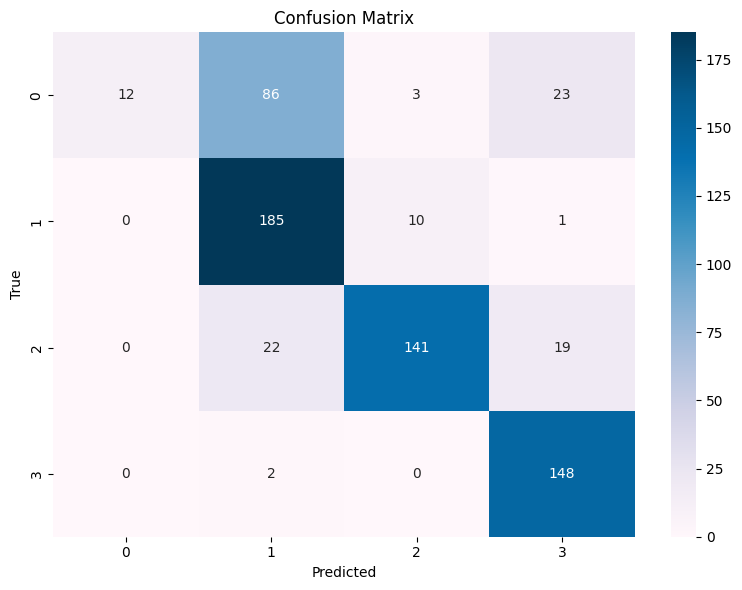

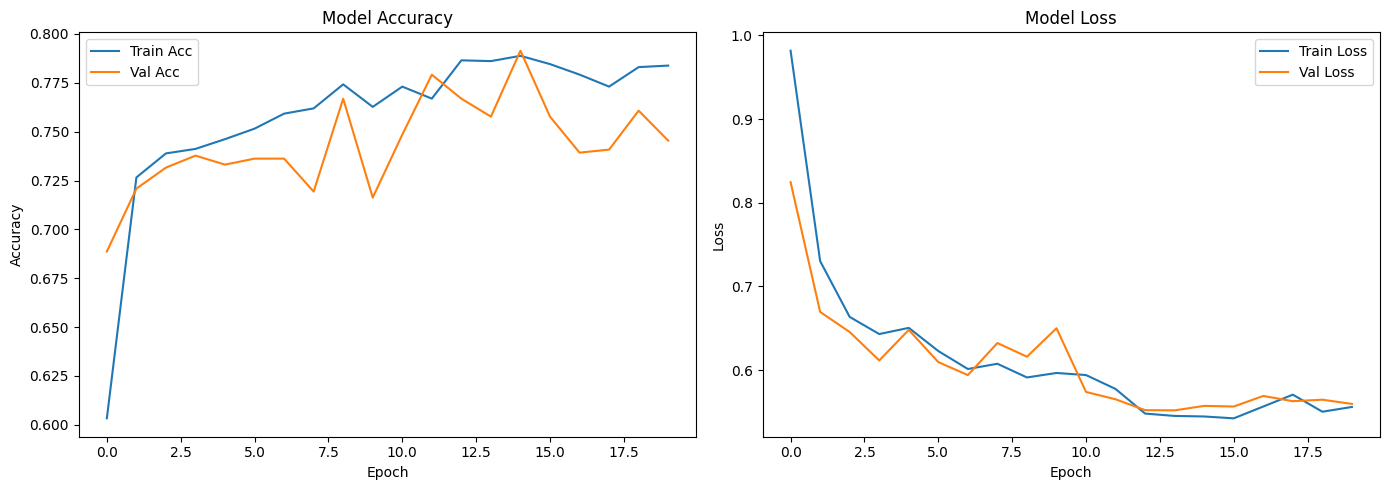

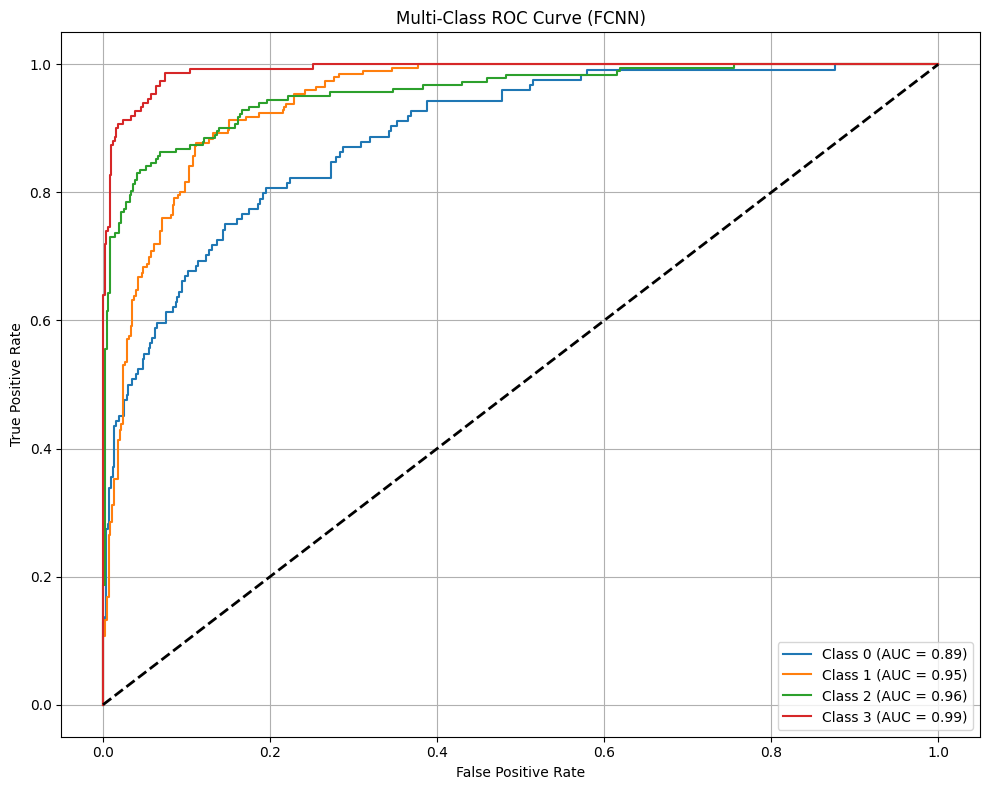

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Define FCNN Model
fcnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile model
fcnn_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train model
history = fcnn_model.fit(X_train, y_train,
                         epochs=20,
                         batch_size=32,
                         validation_data=(X_test, y_test),
                         verbose=1)

# Save model
fcnn_model.save("/content/fcnn_resnet50.h5")
print("✅ FCNN model saved as 'fcnn_resnet50.h5'")

# Evaluate model
y_pred_probs = fcnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_probs, multi_class="ovr")

print("\n✅ **FCNN Model Evaluation:**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuBu",
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve (multi-class)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {np.unique(y_train)[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Multi-Class ROC Curve (FCNN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


## Step 10: Evaluate FCNN Model

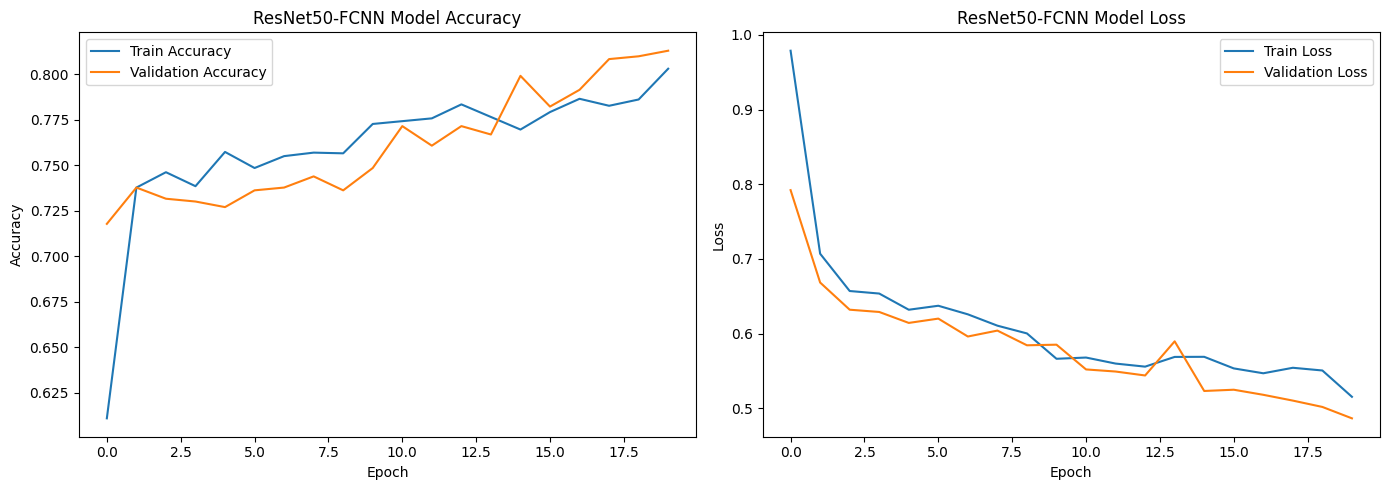

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50-FCNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50-FCNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## RESNET101

In [20]:
# Load ResNet-101 features
features_101 = np.load("/content/resnet101_features.npy")
df = pd.read_csv("/content/leukemia_dataset.csv")

# Load label encoder
with open("/content/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Encode labels
y = label_encoder.transform(df["Label"].values)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_101, y, test_size=0.2, random_state=42)


✅ **SVM Classifier (ResNet-101) Performance:**
Accuracy: 0.8620
Precision: 0.8629
Recall: 0.8620
F1-score: 0.8604
AUC-ROC: 0.9752
✅ SVM model saved as 'svm_resnet101.pkl'


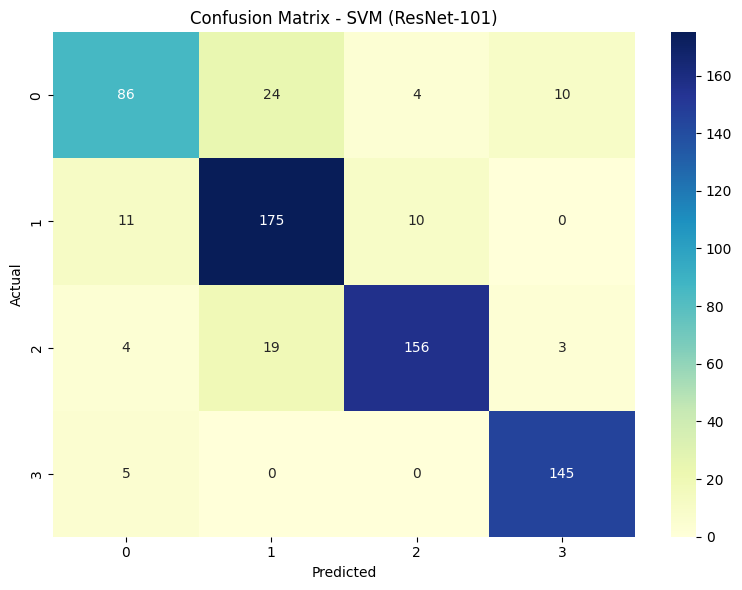

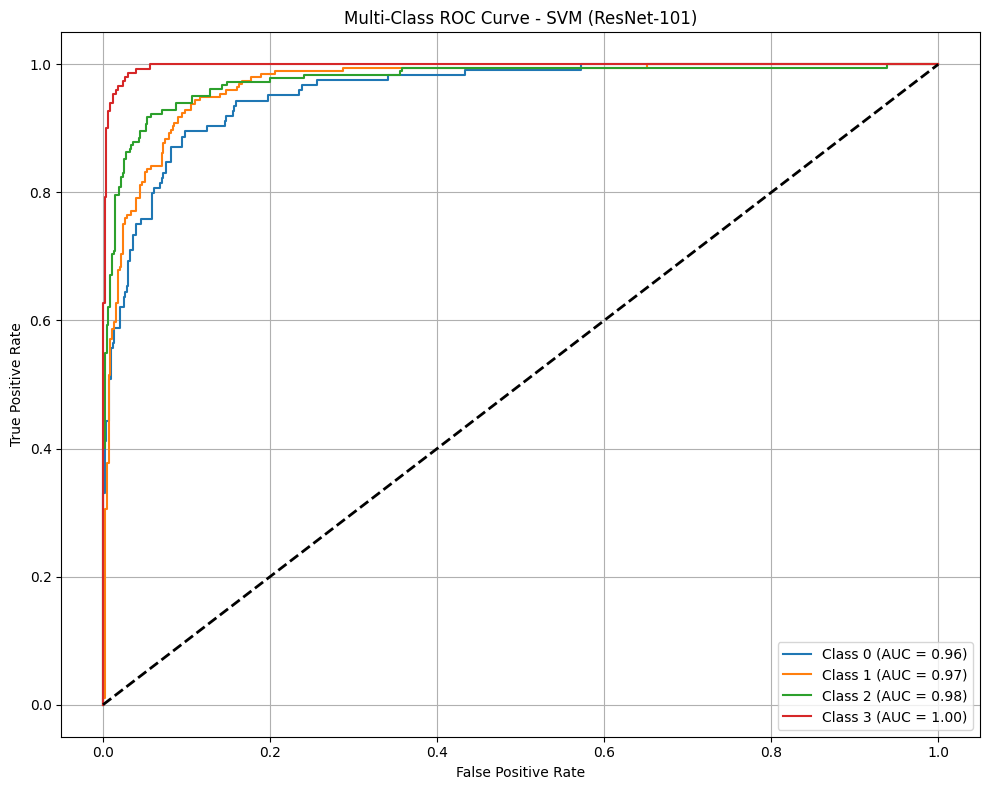

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle

# Train SVM
svm_classifier = SVC(kernel="linear", probability=True)
svm_classifier.fit(X_train, y_train)

# Predict & Evaluate
y_pred = svm_classifier.predict(X_test)
y_pred_probs = svm_classifier.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_roc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, multi_class="ovr")

# Print results
print(f"✅ **SVM Classifier (ResNet-101) Performance:**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Save model
with open("/content/svm_resnet101.pkl", "wb") as f:
    pickle.dump(svm_classifier, f)
print("✅ SVM model saved as 'svm_resnet101.pkl'")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title("Confusion Matrix - SVM (ResNet-101)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve (Multi-class)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {np.unique(y_train)[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Multi-Class ROC Curve - SVM (ResNet-101)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ **Softmax Classifier (ResNet-101) Performance:**
Accuracy: 0.8482
Precision: 0.8498
Recall: 0.8482
F1-score: 0.8454
AUC-ROC: 0.9721
✅ Softmax model saved as 'softmax_resnet101.pkl'


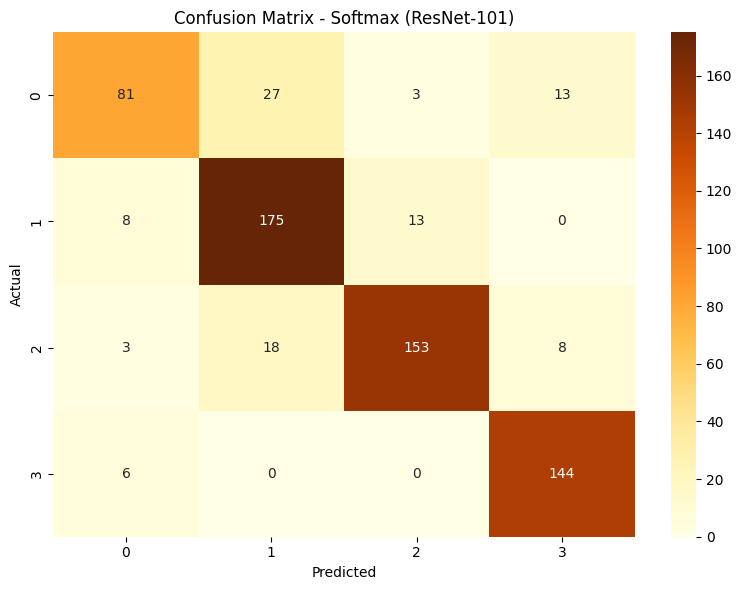

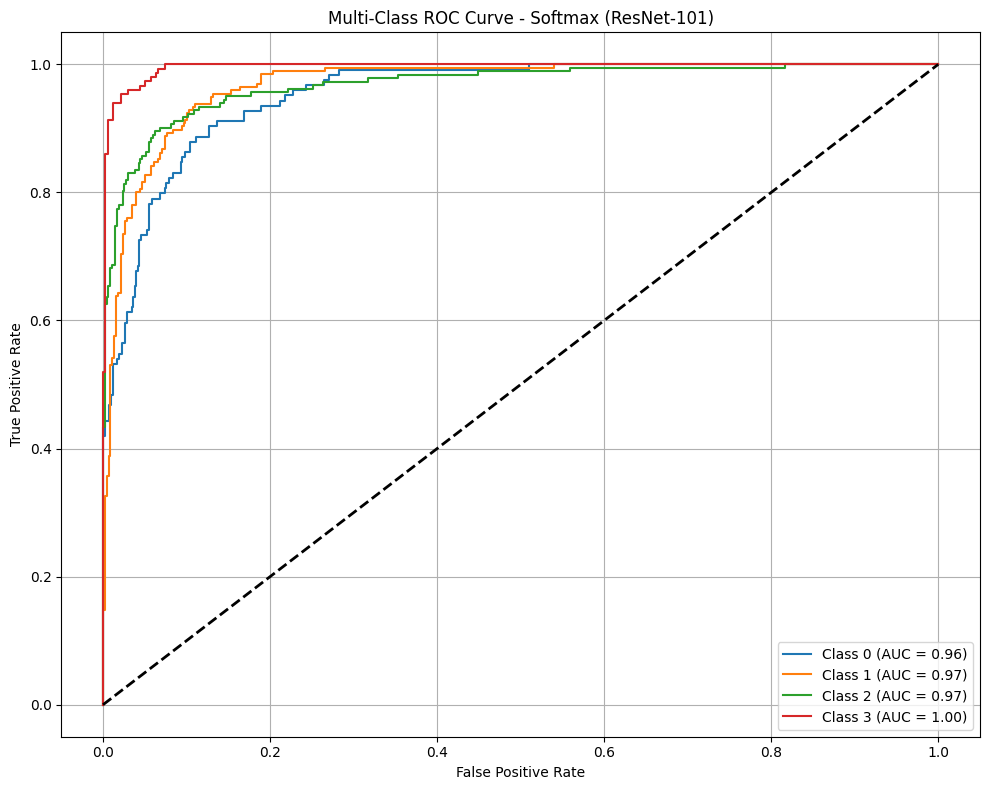

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Train Softmax classifier
softmax_classifier = LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs')
softmax_classifier.fit(X_train, y_train)

# Predict & Evaluate
y_pred = softmax_classifier.predict(X_test)
y_pred_probs = softmax_classifier.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_roc = roc_auc_score(pd.get_dummies(y_test), y_pred_probs, multi_class="ovr")

# Print results
print(f"✅ **Softmax Classifier (ResNet-101) Performance:**")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Save model
with open("/content/softmax_resnet101.pkl", "wb") as f:
    pickle.dump(softmax_classifier, f)
print("✅ Softmax model saved as 'softmax_resnet101.pkl'")

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrBr",
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title("Confusion Matrix - Softmax (ResNet-101)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 📈 Multi-Class ROC Curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {np.unique(y_train)[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Multi-Class ROC Curve - Softmax (ResNet-101)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5175 - loss: 1.1438 - val_accuracy: 0.6979 - val_loss: 0.7450
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7235 - loss: 0.7386 - val_accuracy: 0.6840 - val_loss: 0.8193
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7258 - loss: 0.6923 - val_accuracy: 0.7163 - val_loss: 0.6774
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7480 - loss: 0.6242 - val_accuracy: 0.7163 - val_loss: 0.6408
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7395 - loss: 0.6276 - val_accuracy: 0.7239 - val_loss: 0.6627
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7559 - loss: 0.6246 - val_accuracy: 0.7009 - val_loss: 0.7351
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7377 - loss: 0.6502 - val_accuracy: 0.7239 - val_loss: 0.6090
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7510 - loss: 0.6211 - val_accuracy: 0.7255 - v

✅ FCNN model saved as 'fcnn_resnet101.h5'


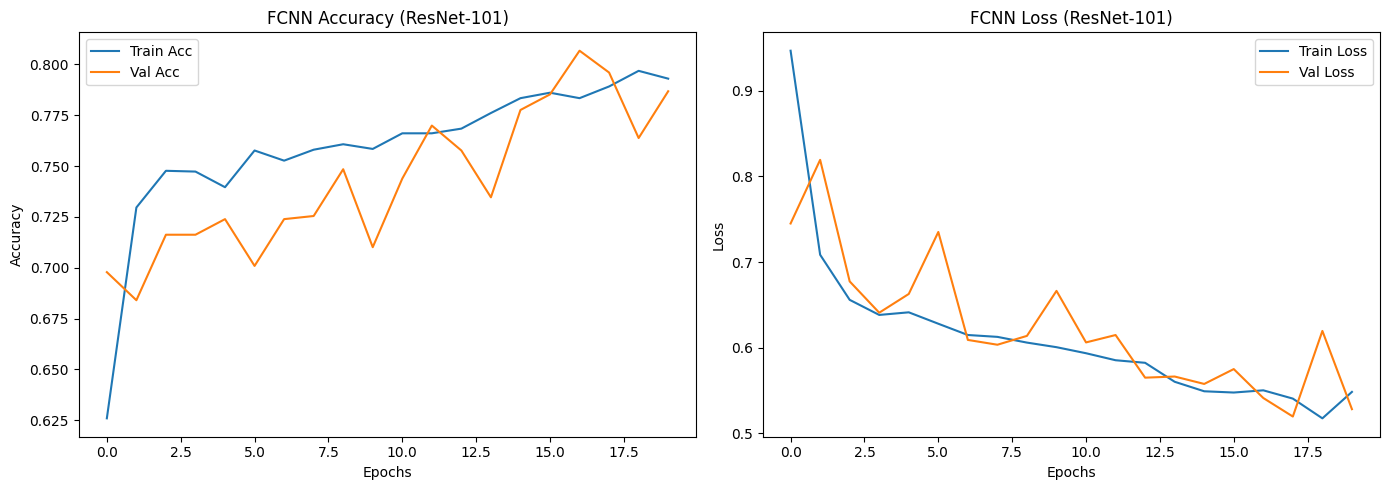

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

✅ **FCNN Classifier (ResNet-101) Performance:**
Accuracy : 0.7868
Precision: 0.7971
Recall   : 0.7868
F1-score : 0.7691
AUC-ROC  : 0.9527


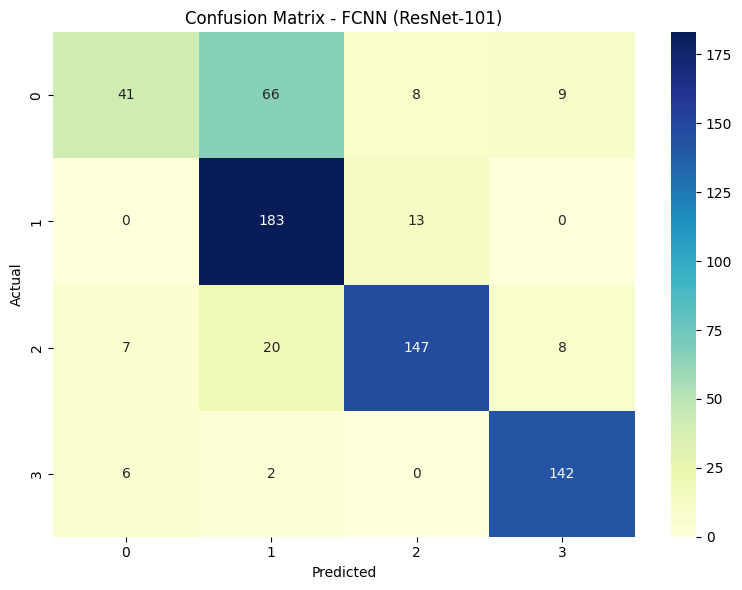

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define FCNN
fcnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile
fcnn_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train
history = fcnn_model.fit(X_train, y_train, epochs=20, batch_size=32,
                         validation_data=(X_test, y_test), verbose=1)

# Save model
fcnn_model.save("/content/fcnn_resnet101.h5")
print("✅ FCNN model saved as 'fcnn_resnet101.h5'")

# 📉 Plot accuracy & loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('FCNN Accuracy (ResNet-101)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('FCNN Loss (ResNet-101)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🔮 Predictions
y_pred_probs = fcnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 🧠 Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")
auc_roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_probs, multi_class='ovr')

print(f"\n✅ **FCNN Classifier (ResNet-101) Performance:**")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc_roc:.4f}")

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title("Confusion Matrix - FCNN (ResNet-101)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7198 - loss: 0.6377
✅ FCNN Test Accuracy: 73.93%


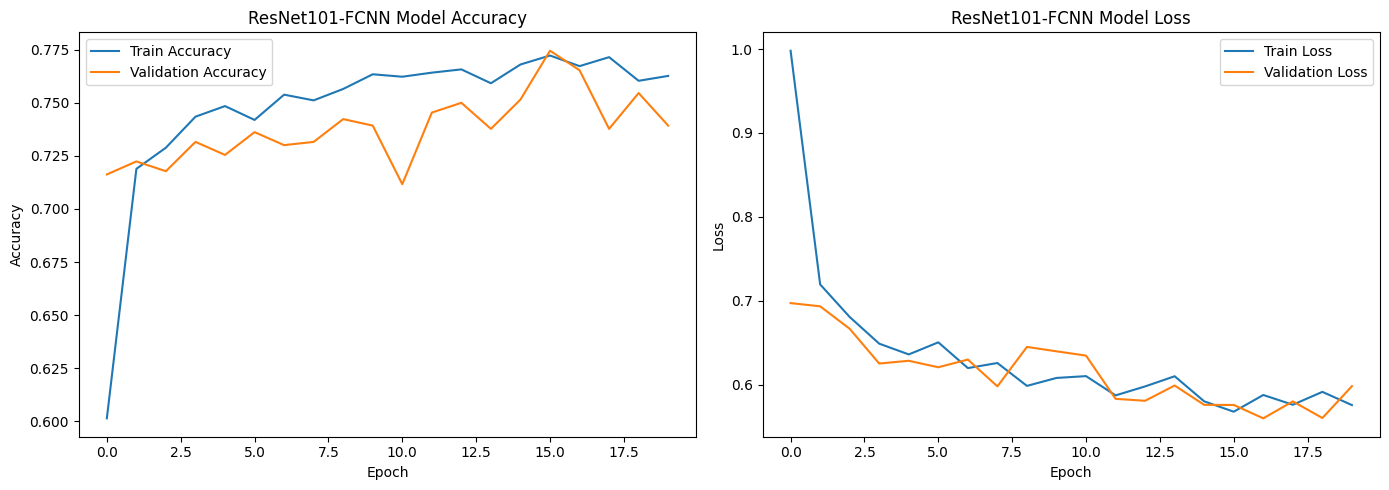

In [ ]:
# Evaluate on test data
loss, acc = fcnn_model.evaluate(X_test, y_test, verbose=1)
print(f"✅ FCNN Test Accuracy: {acc * 100:.2f}%")

# Plot training & validation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101-FCNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet101-FCNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
